# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 4 - RNN



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
plt.style.use("ggplot")
from copy import deepcopy
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint


Using TensorFlow backend.


In [3]:
import keras
import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras import backend

from keras.models import Model, Input, Sequential,model_from_json
ls import SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization, LSTM, Flatten


print(keras.__version__)
print(tf.__version__)

2.2.4
1.12.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.set_random_seed(456)

<div class='explication'> </div>


## Part 1: Read the data

Read in data ```HW4_data.csv``` and use the  code below to open the csv as a pandas dataframe.

As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity

In [7]:
# Given code
path_dataset = './HW4_data.csv'
data = pd.read_csv(path_dataset, encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


<div class='exercise'><b> Question 1.  Prepare Data [20pt]</b></div>


<span class='sub-q'> **Question 1.1**</span> 
* (1) Create a list of unique words found in column 'Word'
* (2) Sort the list in alphabetic order
* (3) Append the special word "ENDPAD" to the end of the list, and store it to a variable ```words```
* (4) Store the length of this list to a variable ```n_words```

<div class='explication'> </div>

In [107]:
words = sorted(list(set(data.Word.values)))+['ENDPAD']
n_words = len(words)

<span class='sub-q'>**Question 1.2**</span>
* (1) Store a list of unique tags into a variable ```tags```, paying attention to sort the list in alphabetic order
* (2) Append the special tag "PAD" to the end of the list
* (3) Store the length of this list to a variable ```n_tags```

<div class='explication'> </div>

In [106]:
tags = sorted(list(set(data.Tag.values)))+['PAD']
n_tags = len(tags)

<span class='sub-q'>**Question 1.3**</span>
* (1) Process data into a list of sentences, each sentence is a list of (word, tag) tuples.

**Example**

First sentence in the list of sentences:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
* (2) Find out the number of words in the longest sentence, and store it to variable ```max_len```


<div class='explication'> </div>

In [11]:
list_sentences = []
for sentence, group in data.groupby(['Sentence #']):
    temp = []
    for i in range(group.shape[0]):
        temp.append((group.iloc[i,1], group.iloc[i,3]))
    list_sentences.append(temp)

In [12]:
print(list_sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [13]:
def longest_sentence(sentences):
    max_len = 0
    for i in range(len(sentences)):
        temp = len(sentences[i])
        if temp > max_len:
            max_len = temp
    return(max_len)

In [14]:
# straightforward function 
max_len = longest_sentence(list_sentences)

In [15]:
# check function 
print(max_len == data.groupby(['Sentence #'])['Word'].count().max())

True


In [10]:
# max_len = 104
# n_tags =18
# n_words = 35179

<span class='sub-q'>**Question 1.4**</span>

It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. To this end, you are required to:
* (1) Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary. 
* (2) Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
* (3) Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```

Your ```X[i]``` now should be something similar to this:

```[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]```
 
* (4) Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

* (5) Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
* (6) apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

* (7) Use the ```to_categorical``` keras function to one-hot encode the tags.

Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```

* (8) Split the dataset in train and test datasets (test 10%).

<div class='explication'> </div>

In [108]:
# word mappings
word2idx = {word: idx for idx,word in enumerate(words)}
idx2word = {idx: word for word, idx in word2idx.items()}

# tag mapping
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [17]:
# sanity checks
error = False
for i in np.random.randint(0,n_words,10):
    if i != word2idx[idx2word[i]]:
        error = True
for i in np.random.randint(0, n_tags,10):
    if i != tag2idx[idx2tag[i]]:
        error = True
if error:
    print('Error')
else:
    print('We\'re good!')

We're good!


In [18]:
# grapn numvber of sentencese
n_sentences = len(list_sentences)
print(n_sentences == data.groupby('Sentence #').ngroups)

True


In [19]:
# mapping 
x = []
y = []
# loop over sentences
for sentence in list_sentences:
    # temporary lists
    # fill X with the words
    # fill Y with the tags
    temp_x = []
    temp_y = []
    for tup in sentence:
        temp_x.append(tup[0])
        temp_y.append(tup[1])
    # map the words in the sentence
    temp_x = list(map(word2idx.get, temp_x))
    # map the tags in the sentence
    temp_y = list(map(tag2idx.get, temp_y))
    x.append(temp_x)
    y.append(temp_y)

In [20]:
# padding 
X = pad_sequences(x, maxlen=max_len, padding= 'post', value= word2idx['ENDPAD'])
Y = pad_sequences(y, maxlen=max_len, padding= 'post', value= tag2idx['PAD'])

In [21]:
print(X[0])
print(Y[0])

[15077 27700 20969 24218 26434 33389  9684 33464 29396 33246 34660 24853
  8204 17364 20924 33246 34973 27700  4010 33786 23512 33242 20368    24
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]
[16 16 16 16 16 16  2 16 16 16 16 16  2 16 16 16 16 16  3 16 16 16 16 16
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17]


In [22]:
error = False
for s1,s2 in zip(X,Y):
    if len(s1) != max_len or len(s2) != max_len:
        error = True
if error:
    print('Error')
else:
    print('Dimensions match!')

Dimensions match!


In [23]:
# create array
X = np.array(X)
# to categorical 
Y = to_categorical(Y)

In [24]:
# split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.1)

<div class="alert alert-block alert-info">

The first portion of the below code refers to 'Sentence 1' with index 1. Index 1 actually is the second sentence, so we will correct 'Sentence 1" to 'Sentence 2'.

</div>

In [22]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
# was:
# print("Sentence 1: {}\n".format(X[1]))
# now:
print("Sentence 2: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 2: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


In [23]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(Y.shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: 16

(47959, 104, 18)


In [27]:
np.save('X',X)

In [28]:
np.save('Y',Y)

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [86]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [34]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40pt]</b></div>

<span class='sub-q'>**Question 2.1**</span>

### Model 1: Baseline Model ###

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])




<div class='explication'> </div>

In [211]:
baseline = np.zeros(n_words)-1
for i in range(n_words):
    msk = np.where(X_train == i)
    temp = Y_train[msk].sum(axis=0).argmax()
    baseline[i] = temp

In [356]:
# Run this cell to show your results #

print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

In [212]:
np.save('baseline', baseline)

### Model 2: Vanilla Feed Forward Neural Network ###

This model is provided to you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.



<span class='sub-q'>**Question 2.2**</span>

(1) Explain what is embedding layer and why we need it here.

(2) Explain why the Param # of Embedding layer is 1758950 (as shown in ```print(model.summary())```).

### Hyperparameters shared with other NN models

In [93]:
# try different params in models
n_units = 100
# n_units = 200
# n_units = 150
drop_rate = .1
# drop_rate = .2
dim_embed = 50
# dim_embed = 100
# dim_embed = 150

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [342]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [343]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [345]:
# Train model
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 7s 176us/step - loss: 0.3150 - acc: 0.9780 - val_loss: 0.0584 - val_acc: 0.9861
Epoch 2/10
38846/38846 [==============================] - 6s 156us/step - loss: 0.0515 - acc: 0.9862 - val_loss: 0.0467 - val_acc: 0.9870
Epoch 3/10
38846/38846 [==============================] - 6s 150us/step - loss: 0.0453 - acc: 0.9872 - val_loss: 0.0441 - val_acc: 0.9876
Epoch 4/10
38846/38846 [==============================] - 6s 153us/step - loss: 0.0430 - acc: 0.9877 - val_loss: 0.0429 - val_acc: 0.9878
Epoch 5/10
38846/38846 [==============================] - 6s 153us/step - loss: 0.0417 - acc: 0.9880 - val_loss: 0.0422 - val_acc: 0.9881
Epoch 6/10
38846/38846 [==============================] - 6s 151us/step - loss: 0.0409 - acc: 0.9883 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 7/10
38846/38846 [==============================] - 6s 152us/step - loss: 0.0403 - acc: 0.9885 - val_loss: 0.0415 - v

In [347]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


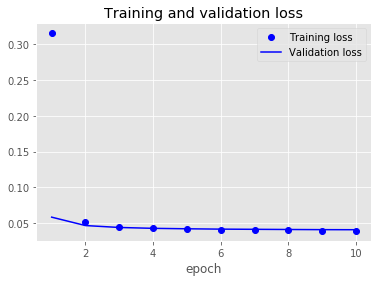

In [348]:
plot_training_history(history)

In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that these codes and parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [57]:
FFNN=load_keras_model('model_FFNN')

def create_truncated_model_FFNN(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_train)

# flatten data
hidden_features_pre = hidden_features
hidden_features=hidden_features.reshape(-1,50)
y_te=Y_train.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9345781323681346


In [100]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

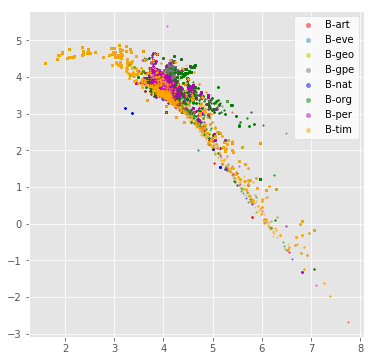

In [361]:
visualize_hidden_features(pca_result)

<div class="alert alert-block alert-info">

(1) An embeddding layer is a transformation from one subspace to a denser subspace. In this example, the embeded layer takes an input of size 'max_len' by 'n_words' to an output of 'max_len' by 'dim_embed.

<br><br>

(2) The embeddding layer is essental a transformation matrix of size 'n_words' by 'dim_embed'; this matrix has 35179*50=1758950 elements, which are the wights (or parameters) tp  learn.

</div>

### Model 3: RNN ###
<span class='sub-q'>**Question 2.3**</span>

(1) Set up a simple RNN model by stacking the following layers in sequence:
* an input layer
* a simple Embedding layer transforming integer words into vectors 
* a dropout layer to regularize the model
* a SimpleRNN layer 
* a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag

(2) Compile the model

(3) Train the model and plot the training history

(4) Visualize outputs from SimpleRNN layer, one subplot for **B-tags** and one subplot for **I-tags**,comment on the patterns you observed.

For hyperparameters use those provided in Model 2

<div class='explication'> </div>

In [103]:
# y_te = y_train

In [83]:
simple_rnn = Sequential()
simple_rnn.add(Embedding(n_words, dim_embed, input_length=max_len))
simple_rnn.add(Dropout(drop_rate))
simple_rnn.add(SimpleRNN(n_units, return_sequences=True))
simple_rnn.add(TimeDistributed(Dense(n_tags, activation='softmax')))
simple_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(simple_rnn.summary())

# Train model
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
simple_rnn_history = simple_rnn.fit(X_train, Y_train, callbacks=callbacks, 
                                    batch_size=batch_size, epochs=15, 
                    validation_split=validation_split, verbose=verbose)
# Final evaluation of the model
scores_simple_rnn = simple_rnn.evaluate(X_test, Y_test, verbose=verbose)
print("Accuracy: %.2f%%" % (scores_simple_rnn[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 104, 50)           1758950   
_________________________________________________________________
dropout_12 (Dropout)         (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 104, 100)          15100     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None
Train on 34530 samples, validate on 8633 samples
Epoch 1/15
34530/34530 [==============================] - 82s 2ms/step - loss: 0.1420 - acc: 0.9662 - val_loss: 0.0399 - val_acc: 0.9898
Epoch 2/15
34530/34530 [==============================] - 80s 2ms/step - 

In [88]:
# save your mode ##
simple_rnn.save('simple_rnn')

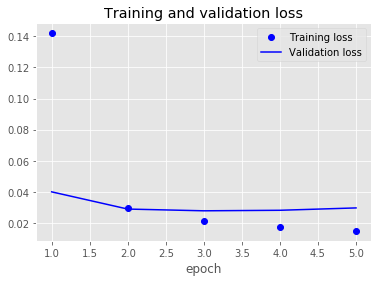

In [87]:
# run this cell to show your results #
plot_training_history(simple_rnn_history)

In [94]:
def create_truncated_RNN(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    return model

In [95]:
truncated_rnn = create_truncated_RNN(simple_rnn)

In [96]:
hidden_features_srnn = truncated_rnn.predict(X_train)

In [97]:
hidden_features_srnn = hidden_features_srnn.reshape(-1,50)

In [98]:
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features_srnn)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.7948452721029701


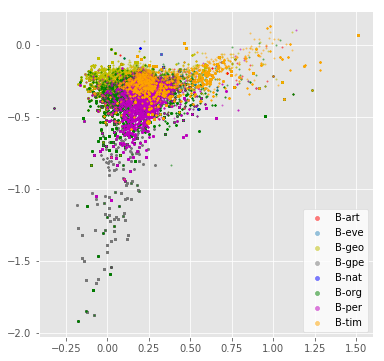

In [123]:
visualize_hidden_features(pca_result)

<div class='explication'> </div>

In [54]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features_i(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for i,cat in enumerate(range(8,7+8+1)):
        indices_I = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_I,0], pca_result[indices_I, 1], label=idx2tag[cat],s=2,color=color[i],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

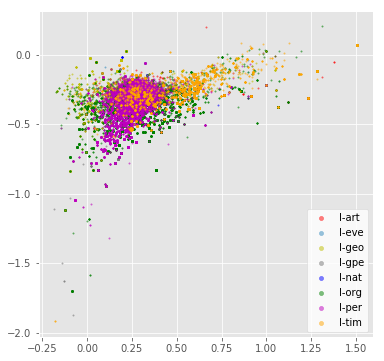

In [125]:
visualize_hidden_features_i(pca_result)

### Model 4: GRU ###

<span class='sub-q'>**Question 2.4**</span>


(1) Briefly explain what is GRU and how it is different from simple RNN

(2) build a GRU architecture by replacing the SimpleRNN cell with a GRU one. 

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

<div class='explication'> </div>

<div class="alert alert-block alert-info">

GRU is a more sophisticated implementation of RNN and a a variant of LSTM which is essentially  built on what we call gates which are themselves composed of an input and forget gates. These gates esstentially provide the model with memory through their update. 

</div>

In [112]:
gru_rnn = Sequential()
gru_rnn.add(Embedding(n_words, dim_embed, input_length=max_len))
gru_rnn.add(Dropout(drop_rate))
gru_rnn.add(GRU(n_units, return_sequences=True))
gru_rnn.add(TimeDistributed(Dense(n_tags, activation='softmax')))
gru_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_rnn.summary())

# Train model
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
gru_rnn_history = gru_rnn.fit(X_train, Y_train, callbacks=callbacks,
                              batch_size=batch_size, epochs=3, 
                    validation_split=validation_split, verbose=verbose)

# Final evaluation of the model
scores_gru_rnn = gru_rnn.evaluate(X_test, Y_test, verbose=verbose)
print("Accuracy: %.2f%%" % (scores_gru_rnn[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 104, 50)           1758950   
_________________________________________________________________
dropout_17 (Dropout)         (None, 104, 50)           0         
_________________________________________________________________
gru_13 (GRU)                 (None, 104, 100)          45300     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 104, 18)           1818      
Total params: 1,806,068
Trainable params: 1,806,068
Non-trainable params: 0
_________________________________________________________________
None
Train on 38846 samples, validate on 4317 samples
Epoch 1/3
38846/38846 [==============================] - 178s 5ms/step - loss: 0.1522 - acc: 0.9672 - val_loss: 0.0390 - val_acc: 0.9901
Epoch 2/3
38846/38846 [==============================] - 176s 5ms/step - 

In [114]:
gru_rnn.save('gru_rnn')

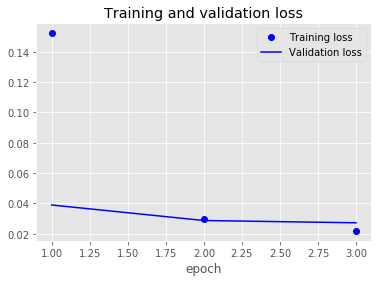

In [113]:
plot_training_history(gru_rnn_history)

In [115]:
def create_truncated_GRU(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [116]:
truncated_gru = create_truncated_GRU(gru_rnn)
hidden_features_gru = truncated_gru.predict(X_train)
hidden_features_gru = hidden_features_gru.reshape(-1,50)
# find first two PCA components
pca = PCA(n_components=2)
pca_result_gru = pca.fit_transform(hidden_features_gru)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.7980289015607513


For the B tages:

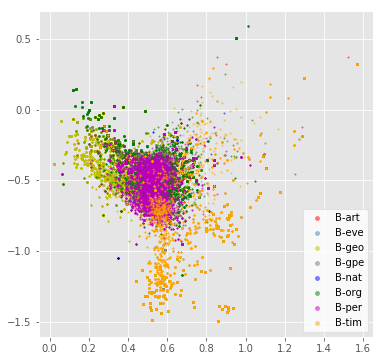

In [52]:
visualize_hidden_features(pca_result_gru)

For the I tags:

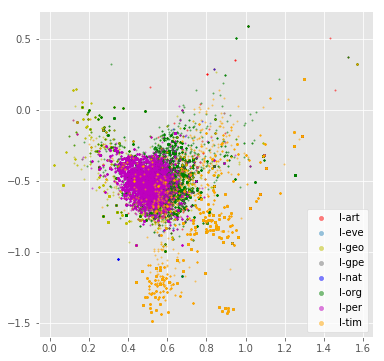

In [55]:
visualize_hidden_features_i(pca_result_gru)

### Model 5: Bidirectional GRU ###
<span class='sub-q'>**Question 2.5**</span>


(1) Explain what is Bidirectional GRU and how it is different from GRU model above.

(2) Then build a bidirectional GRU by wrapping your GRU layer into a Bidirectional one

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

<div class='explication'> </div>

<div class="alert alert-block alert-info">

A bidirectional GRU is just like the previous (forward directional) GRU with the modification that the sequences of values is analyzed from the end to the start in addition to being analyzed from the start to the end. 

</div>

In [ ]:
bi_gru_rnn = Sequential()
bi_gru_rnn.add(Embedding(n_words, dim_embed, input_length=max_len))
bi_gru_rnn.add(Dropout(drop_rate))
bi_gru_rnn.add(Bidirectional(GRU(n_units, return_sequences=True)))
bi_gru_rnn.add(TimeDistributed(Dense(n_tags, activation='softmax')))
bi_gru_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_gru_rnn.summary())

# Train model
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
bi_gru_rnn_history = bi_gru_rnn.fit(X_train, Y_train, callbacks=callbacks, 
                                    batch_size=batch_size, epochs=3, 
                    validation_split=validation_split, verbose=verbose)


# Final evaluation of the model
scores_bi_gru_rnn = bi_gru_rnn.evaluate(X_test, Y_test, verbose=verbose)
print("Accuracy: %.2f%%" % (scores_bi_gru_rnn[1]*100))

In [58]:
# save your model #
bi_gru_rnn.save('bi_gru_rnn')

Saved model to disk


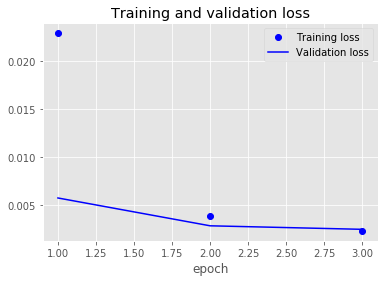

In [59]:
# run this cell to show your results #
plot_training_history(bi_gru_rnn_history)

In [60]:
truncated_gru_bi = create_truncated_GRU(bi_gru_rnn)
hidden_features_gru_bi = truncated_gru_bi.predict(X_train)
hidden_features_gru_bi = hidden_features_gru_bi.reshape(-1,50)
# find first two PCA components
pca = PCA(n_components=2)
pca_result_gru_bi = pca.fit_transform(hidden_features_gru_bi)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.7846508777640635


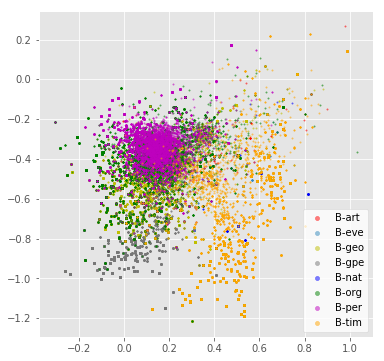

In [61]:
visualize_hidden_features(pca_result_gru_bi)

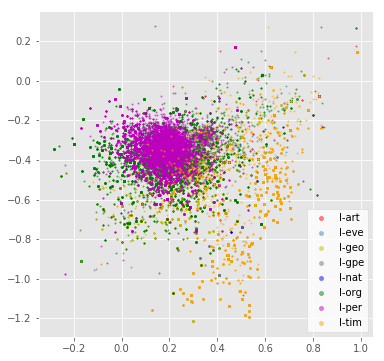

In [62]:
visualize_hidden_features_i(pca_result_gru_bi)

In [63]:
simple_rnn.save('simple_rnn.h5')

In [66]:
gru_rnn.save('gru.h5')

In [65]:
bi_gru_rnn.save('bi_gru_rnn.h5')

In [70]:
FFNN=load_keras_model('model_FFNN')

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


<span class='sub-q'>**Question 3.1**</span>


For each model iteratively:

(1) Load the model using the given function ```load_keras_model```

(2) Apply the model to the test dataset

(3) Compute an F1 score for each ```Tag``` and store it 

(4) Plot the F1 score per Tag and per model making use of a grouped barplot.

(5) Briefly discuss the performance of each model

In [226]:
base_preds = np.zeros((X_test.shape[0], max_len))-1 
for i in range(base_preds.shape[0]):
    base_preds[i,:] = baseline[X_test[i,:]]

In [67]:
fnn_preds = FFNN.predict(X_test)
rnn_preds = simple_rnn.predict(X_test)
gru_preds = gru_rnn.predict(X_test)
bi_gru_preds = bi_gru_rnn.predict(X_test)

In [260]:
np.save('base_preds', base_preds)
np.save('fnn_preds', fnn_preds)
np.save('rnn_preds', rnn_preds)
np.save('gru_preds', gru_preds)
np.save('bi_gru_preds', bi_gru_preds)

In [240]:
fnn_preds = base_preds.argmax(-1)
rnn_preds = simple_rnn.predict(X_test).argmax(-1)
gru_preds = gru_rnn.predict(X_test).argmax(-1)
bi_gru_preds = bi_gru_rnn.predict(X_test).argmax(-1)

In [43]:
def f1(true, pred, i):
    # true positive 
    tp = np.sum(pred[np.where(true==i)] == i)
    
    # 0
    if tp == 0:
        return(0)
    
    # false negative 
    fn = np.sum(pred[np.where(true==i)] != i)
    # false positive 
    fp = np.sum((true[np.where(pred==i)] != i))
    # true negative
    tn = np.sum((pred[np.where(true!=i)] != i))
    
    # precision 
    prec = tp/(tp+fp)
    # recall
    rec = tp/(tp+fn)
    
    # f1 score
    f1 = 2*(prec*rec)/(prec+rec)
    
    return(f1)

In [313]:
# number of models
n_models = 5
model_preds = {0: base_preds, 1: fnn_preds, 2: rnn_preds, 3: gru_preds, 4: bi_gru_preds}
model_names = {0: 'base_preds', 1: 'fnn_preds', 2: 'rnn_preds', 3: 'gru_preds', 4: 'bi_gru_preds'}
Yt = Y_test.argmax(-1)

In [314]:
scores = np.zeros((n_models, n_tags))-1
for model in range(n_models):
    for tag in range(n_tags):
        scores[model, tag] = f1(Yt, model_preds[model], tag)

In [316]:
scores_df = pd.DataFrame(data= scores, columns=tags, r)
scores_df.index = list(model_names.values())

In [348]:
display(scores_df)

,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,I-art,I-eve,I-geo,I-gpe,I-nat,I-org,I-per,I-tim,O,PAD
base_preds,0.028032,0.301887,0.828180,0.932733,0.450000,0.603218,0.742892,0.817587,0.000000,0.312500,0.661041,0.444444,0.0,0.626156,0.711538,0.207171,0.983355,1.000000
fnn_preds,0.230769,0.333333,0.820000,0.918011,0.410256,0.601479,0.737833,0.797268,0.000000,0.285714,0.646314,0.461538,0.0,0.618735,0.746040,0.252207,0.984158,1.000000
rnn_preds,0.181818,0.372093,0.848831,0.936733,0.307692,0.666183,0.836222,0.858729,0.108108,0.129032,0.780253,0.560000,0.2,0.772589,0.869641,0.737949,0.987804,0.999987
gru_preds,0.000000,0.000000,0.843477,0.920065,0.000000,0.638957,0.787860,0.840878,0.000000,0.000000,0.731944,0.000000,0.0,0.726946,0.840941,0.689266,0.987929,0.999895
bi_gru_preds,0.000000,0.000000,0.865843,0.932943,0.000000,0.720911,0.831858,0.870657,0.000000,0.000000,0.778689,0.000000,0.0,0.777847,0.858982,0.732824,0.989068,0.999983


In [356]:
print('Mean F1 Score across tags for each model')
print(scores.mean(axis=1))

Mean F1 Score across tags for each model
[0.53615186 0.5468698  0.61964813 0.50045326 0.5199781 ]


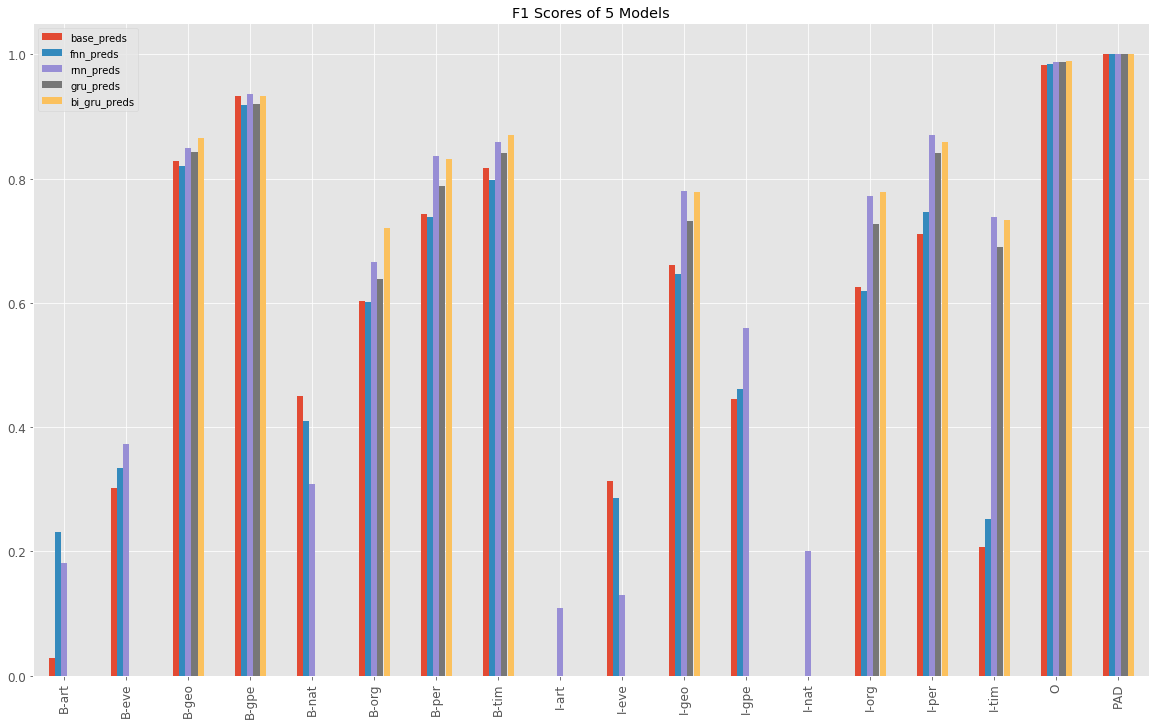

In [350]:
scores_df.T.plot(kind='bar', title ='F1 Scores of 5 Models', figsize=(20, 12), legend=True, fontsize=12);

<div class="alert alert-block alert-info">

We see from the above plots that the simple RNN model performed the ebst across the board. For tags which most models were able to predict fairly well, we see that the F! scores are low across the board except for the simple RNN; the latter is the reason why the mean F1 score across the tags for the simple RNN is highest. 

</div>

<span class='sub-q'>**Question 3.2**</span>

(1) Which tags have the lowest f1 score? 

For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="./data/B_art.png" alt="drawing" width="600"/>


(2) Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [430]:
sorted_tags = list(scores_df.columns[scores.mean(axis=0).argsort()])
print(sorted_tags)

['I-art', 'I-nat', 'B-art', 'I-eve', 'B-eve', 'B-nat', 'I-gpe', 'I-tim', 'B-org', 'I-org', 'I-geo', 'B-per', 'I-per', 'B-tim', 'B-geo', 'B-gpe', 'O', 'PAD']


<div class="alert alert-block alert-info">

We see that that the art tags for both the I and B tags are the worst classified. 

</div>

In [454]:
i_I = 0
i_B = 2
iI, iB = tag2idx[sorted_tags[i_I]], tag2idx[sorted_tags[i_B]]
print(iI, iB)

8 0


In [523]:
np.random.seed(1234)
s = np.random.choice(np.where(Yt == iI)[0])
end = list(map(idx2word.get, X[s])).index('ENDPAD')-1

In [524]:
cols = ['Word', 'y_true'] + list(model_names.values())
print(cols)

['Word', 'y_true', 'base_preds', 'fnn_preds', 'rnn_preds', 'gru_preds', 'bi_gru_preds']


In [525]:
N = n_models+2 # +2 for word and y_true column
missc = np.zeros((end, N))
df = pd.DataFrame(data=missc, columns=cols)
# word 
df.iloc[:,0] = list(map(idx2word.get, X[s,:end]))
# y_true 
df.iloc[:,1] = list(map(idx2tag.get, Yt[s, :end]))
# models
for model,i in enumerate(range(2,N)):
    df.iloc[:,i] = list(map(idx2tag.get, model_preds[model][s,:end]))

In [526]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [527]:
# run this cell to show you result #
display(df.style.apply(highlight_errors, axis=1))

,Word,y_true,base_preds,fnn_preds,rnn_preds,gru_preds,bi_gru_preds
0,Security,O,O,O,O,O,O
1,officials,O,O,O,O,O,O
2,in,O,O,O,O,O,O
3,Afghanistan,O,O,O,O,O,O
4,say,B-art,B-geo,B-geo,B-geo,B-geo,B-geo
5,a,I-art,I-tim,O,I-geo,I-geo,I-geo
6,roadside,O,O,O,O,O,O
7,bomb,B-tim,B-tim,B-tim,B-tim,B-tim,B-tim
8,has,I-tim,B-tim,B-tim,I-tim,I-tim,I-tim
9,ripped,O,O,O,O,O,O


<span class='sub-q'>**Question 3.3**</span>

(1) Choose one of the most promising models you have built, improve this model to achieve the f1 score higher than 0.8 for as many tags as possible ( you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, ... )

(2) Explain why you choose to change certain elements of the model and how effective those adjustments are.


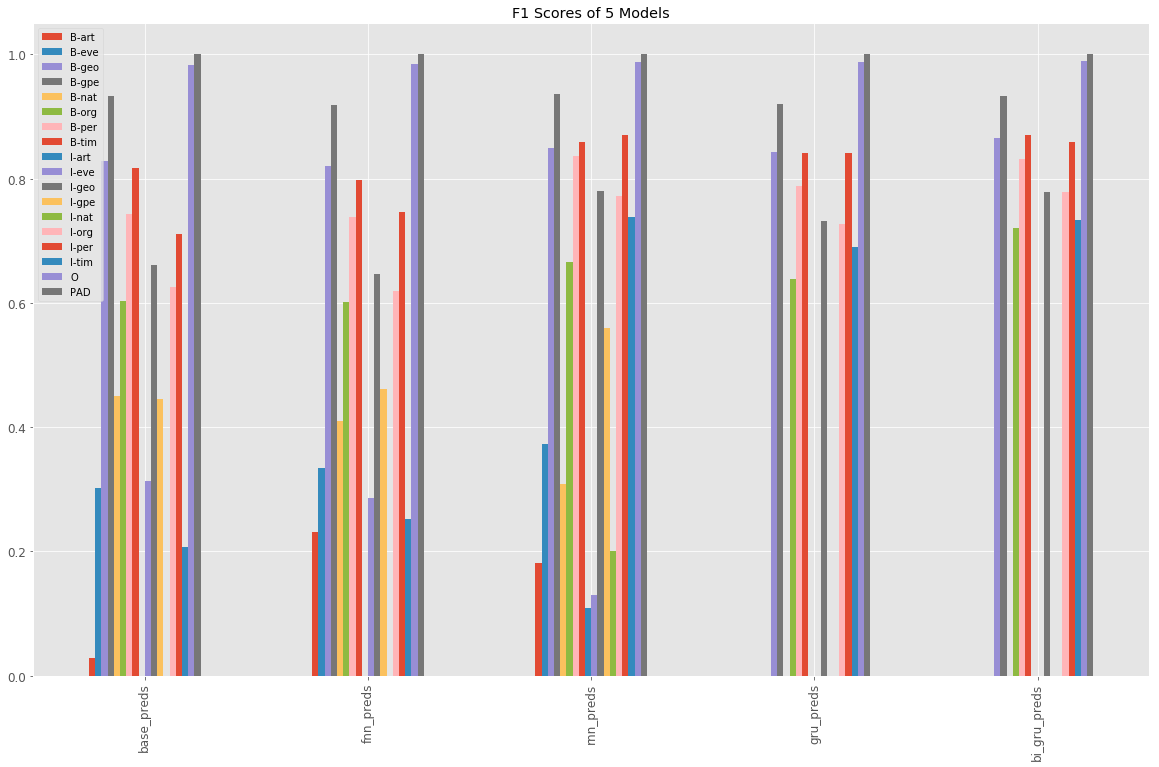

In [528]:
scores_df.plot(kind='bar', title ='F1 Scores of 5 Models', figsize=(20, 12), legend=True, fontsize=12);

<div class="alert alert-block alert-info">

We'll choose to start from the bidirectional GRU as it achieves above or close to above 0.8 F1 score for a lot of tags except the difficult tags. Then, we will consider the SimpleRNN which did do better on the dofficult classes. 

</div>

In [161]:
# X = np.load('X.npy')
# Y = np.load('Y.npy')
# # split 
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.1)
# np.random.seed(42)
# xx = np.arange(X_train.shape[0])
# x_train = X_train[xx, :]
# y_train = Y_train[xx, :]
# max_len = 104
# n_tags =18
# n_words = 35179
# dim_embed  = 50
# drop_rate = 0.1
# n_units = 100
# batch_size = 32
# verbose = 1
# validation_split = 0.2
# Yt = Y_test.argmax(-1)

### Conv1d with Bidirectional GRU

In [162]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [163]:
model = Sequential()
model.add(Embedding(n_words, dim_embed, input_length=max_len))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(100, return_sequences=True)))
model.add(TimeDistributed(Dense(n_tags, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 104, 50)           1758950   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 104, 64)           9664      
_________________________________________________________________
dropout_23 (Dropout)         (None, 104, 64)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 104, 200)          99000     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 104, 18)           3618      
Total params: 1,871,232
Trainable params: 1,871,232
Non-trainable params: 0
_________________________________________________________________
None


In [164]:
history = model.fit(x_train, # Features
                      y_train, # Target vector
                      epochs=15, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      verbose=verbose, # Print description after each epoch
                      batch_size=64, # Number of observations per batch
                      validation_split=0.2) # Data for evaluation

Train on 34530 samples, validate on 8633 samples
Epoch 1/15
34530/34530 [==============================] - 161s 5ms/step - loss: 0.1580 - acc: 0.9654 - val_loss: 0.0452 - val_acc: 0.9871
Epoch 2/15
34530/34530 [==============================] - 157s 5ms/step - loss: 0.0312 - acc: 0.9911 - val_loss: 0.0277 - val_acc: 0.9920
Epoch 3/15
34530/34530 [==============================] - 157s 5ms/step - loss: 0.0203 - acc: 0.9941 - val_loss: 0.0250 - val_acc: 0.9929
Epoch 4/15
34530/34530 [==============================] - 156s 5ms/step - loss: 0.0166 - acc: 0.9951 - val_loss: 0.0247 - val_acc: 0.9930
Epoch 5/15
34530/34530 [==============================] - 157s 5ms/step - loss: 0.0144 - acc: 0.9956 - val_loss: 0.0249 - val_acc: 0.9928
Epoch 6/15
34530/34530 [==============================] - 157s 5ms/step - loss: 0.0129 - acc: 0.9960 - val_loss: 0.0251 - val_acc: 0.9930


In [165]:
# Final evaluation of the model
model_score = model.evaluate(X_test, Y_test, verbose=verbose)
print("Accuracy: %.2f%%" % (model_score[1]*100))

4796/4796 [==============================] - 16s 3ms/step
Accuracy: 99.58%


In [166]:
model_preds = model.predict(X_test).argmax(-1)

In [167]:
model_scores_f1 = np.zeros(n_tags)-1
for tag in range(n_tags):
    model_scores_f1[tag] = f1(Yt, model_preds, tag)

In [168]:
model_scores_f1

array([0.        , 0.        , 0.02995008, 0.01974522, 0.        ,
       0.02411533, 0.03343109, 0.01820359, 0.        , 0.        ,
       0.00402685, 0.        , 0.        , 0.01672141, 0.02567164,
       0.00439239, 0.66767375, 0.94542471])

In [169]:
model_scores_f1.mean()

0.09940867012833278

### Conv1d with SimpleRNN

In [170]:
model_2 = Sequential()
model_2.add(Embedding(n_words, dim_embed, input_length=max_len))
model_2.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(SimpleRNN(150, return_sequences=True))
model_2.add(TimeDistributed(Dense(n_tags, activation='softmax')))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_2.h5', monitor='val_loss', save_best_only=True)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 104, 50)           1758950   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 104, 64)           9664      
_________________________________________________________________
dropout_24 (Dropout)         (None, 104, 64)           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 104, 150)          32250     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 104, 18)           2718      
Total params: 1,803,582
Trainable params: 1,803,582
Non-trainable params: 0
_________________________________________________________________
None


In [171]:
history = model_2.fit(x_train, # Features
                      y_train, # Target vector
                      epochs=15, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      verbose=verbose, # Print description after each epoch
                      batch_size=64, # Number of observations per batch
                      validation_split=0.2) # Data for evaluation

Train on 34530 samples, validate on 8633 samples
Epoch 1/15
34530/34530 [==============================] - 46s 1ms/step - loss: 0.1672 - acc: 0.9595 - val_loss: 0.0529 - val_acc: 0.9849
Epoch 2/15
34530/34530 [==============================] - 43s 1ms/step - loss: 0.0346 - acc: 0.9905 - val_loss: 0.0266 - val_acc: 0.9925
Epoch 3/15
34530/34530 [==============================] - 44s 1ms/step - loss: 0.0210 - acc: 0.9940 - val_loss: 0.0242 - val_acc: 0.9930
Epoch 4/15
34530/34530 [==============================] - 44s 1ms/step - loss: 0.0167 - acc: 0.9950 - val_loss: 0.0239 - val_acc: 0.9931
Epoch 5/15
34530/34530 [==============================] - 43s 1ms/step - loss: 0.0143 - acc: 0.9956 - val_loss: 0.0243 - val_acc: 0.9931
Epoch 6/15
34530/34530 [==============================] - 43s 1ms/step - loss: 0.0126 - acc: 0.9960 - val_loss: 0.0252 - val_acc: 0.9931


In [172]:
# Final evaluation of the model
model_2_score = model_2.evaluate(X_test, Y_test, verbose=verbose)
print("Accuracy: %.2f%%" % (model_2_score[1]*100))

4796/4796 [==============================] - 5s 1ms/step
Accuracy: 99.59%


In [173]:
model_2_preds = model_2.predict(X_test).argmax(-1)

In [174]:
model_2_scores_f1 = np.zeros(n_tags)-1
for tag in range(n_tags):
    model_2_scores_f1[tag] = f1(Yt, model_2_preds, tag)

In [175]:
model_2_scores_f1

array([0.        , 0.        , 0.02790819, 0.01976411, 0.        ,
       0.02605364, 0.03295386, 0.01783061, 0.        , 0.        ,
       0.00410397, 0.        , 0.        , 0.01652893, 0.02536873,
       0.00466563, 0.66910957, 0.94542993])

In [176]:
model_2_scores_f1.mean()

0.09942873141008203

### Conv1d with Forward directional GRU

In [177]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_3.h5', monitor='val_loss', save_best_only=True)]
model_3 = Sequential()
model_3.add(Embedding(n_words, dim_embed, input_length=max_len))
model_3.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(GRU(100, return_sequences=True))
model_3.add(TimeDistributed(Dense(n_tags, activation='softmax')))
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 104, 50)           1758950   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 104, 64)           9664      
_________________________________________________________________
dropout_25 (Dropout)         (None, 104, 64)           0         
_________________________________________________________________
gru_18 (GRU)                 (None, 104, 100)          49500     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 104, 18)           1818      
Total params: 1,819,932
Trainable params: 1,819,932
Non-trainable params: 0
_________________________________________________________________
None


In [178]:
history = model_3.fit(x_train, # Features
                      y_train, # Target vector
                      epochs=15, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      verbose=verbose, # Print description after each epoch
                      batch_size=64, # Number of observations per batch
                      validation_split=0.2) # Data for evaluation

Train on 34530 samples, validate on 8633 samples
Epoch 1/15
34530/34530 [==============================] - 89s 3ms/step - loss: 0.1898 - acc: 0.9626 - val_loss: 0.0497 - val_acc: 0.9861
Epoch 2/15
34530/34530 [==============================] - 86s 2ms/step - loss: 0.0351 - acc: 0.9905 - val_loss: 0.0279 - val_acc: 0.9923
Epoch 3/15
34530/34530 [==============================] - 85s 2ms/step - loss: 0.0211 - acc: 0.9940 - val_loss: 0.0251 - val_acc: 0.9928
Epoch 4/15
34530/34530 [==============================] - 85s 2ms/step - loss: 0.0170 - acc: 0.9950 - val_loss: 0.0249 - val_acc: 0.9927
Epoch 5/15
34530/34530 [==============================] - 86s 2ms/step - loss: 0.0148 - acc: 0.9955 - val_loss: 0.0247 - val_acc: 0.9929
Epoch 6/15
34530/34530 [==============================] - 85s 2ms/step - loss: 0.0134 - acc: 0.9958 - val_loss: 0.0251 - val_acc: 0.9930
Epoch 7/15
34530/34530 [==============================] - 85s 2ms/step - loss: 0.0121 - acc: 0.9962 - val_loss: 0.0260 - val_acc:

In [179]:
# Final evaluation of the model
model_3_score = model_3.evaluate(X_test, Y_test, verbose=verbose)
print("Accuracy: %.2f%%" % (model_3_score[1]*100))

4796/4796 [==============================] - 9s 2ms/step
Accuracy: 99.59%


In [180]:
model_3_preds = model_3.predict(X_test).argmax(-1)

In [181]:
model_3_scores_f1 = np.zeros(n_tags)-1
for tag in range(n_tags):
    model_3_scores_f1[tag] = f1(Yt, model_3_preds, tag)

In [182]:
model_3_scores_f1

array([0.        , 0.        , 0.02790575, 0.02031101, 0.        ,
       0.02526629, 0.03252033, 0.01912046, 0.        , 0.        ,
       0.00398142, 0.        , 0.        , 0.01660243, 0.02654084,
       0.00471328, 0.66792413, 0.94543071])

In [183]:
model_3_scores_f1.mean()

0.09946203590040469

In [265]:
# Yt = Y_train.argmax(-1)
# weights = {}
# N_elem = Yt.shape[0]*Yt.shape[1]
# for tag in range(n_tags):
#     weights[tag] = np.sum(Yt == tag)/N_elem

# callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#              ModelCheckpoint(filepath='best_model_4.h5', monitor='val_loss', save_best_only=True)]
# model_4 = Sequential()
# model_4.add(Embedding(n_words, dim_embed, input_length=max_len))
# model_4.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
# model_4.add(Dropout(0.2))
# model_4.add(GRU(100, return_sequences=True))
# model_4.add(TimeDistributed(Dense(n_tags, activation='softmax')))
# model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model_4.summary())

In [266]:
# history = model_4.fit(x_train, # Features
#                       y_train, # Target vector
#                       epochs=15, # Number of epochs
#                       callbacks=callbacks, # Early stopping
#                       verbose=verbose, # Print description after each epoch
#                       batch_size=64, # Number of observations per batch
#                       validation_split=0.2, # Data for evaluation
#                      class_weight=weights) 

In [267]:
# # Final evaluation of the model
# model_4_score = model_4.evaluate(X_test, Y_test, verbose=verbose)
# print("Accuracy: %.2f%%" % (model_4_score[1]*100))

In [268]:
# model_4_preds = model_4.predict(X_test).argmax(-1)

In [269]:
# model_4_scores_f1 = np.zeros(n_tags)-1
# for tag in range(n_tags):
#     model_4_scores_f1[tag] = f1(Y_test.argmax(-1), model_4_preds, tag)

In [270]:
# model_3_scores_f1

In [271]:
# model_3_scores_f1.mean()

<div class="alert alert-block alert-info">

The previous models were missidentifying certain classes such as article. By adding a convultional layer, we  look to capture articles as they are sandwhiched between other grammatical objects. Doing this, however, marginally improves the F1 score. We adjusted hyperparameters but do not manage to substantially increase the F! score. THe difficult to class targets are just not represented enough. We attempt to use the class wieght feature when we fit, but that does not seem to work. I would have liked to implement a weighted categorical cross entropy loss function for the model but I cannot properly match the tensorflow backend to do this as I have done for weighted binary cross entropy as follows:

</div>

```python
# define new loss to keras from tf
# the weighted binary cross entropy loss
# multiplier for positive targets
POS_WEIGHT = np.reciprocal(np.sum(y_train[:,1] == 1)/np.sum(y_train[:,1] == 0))  
def weighted_binary_crossentropy(target, output):
    # transform back to logits
    epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, epsilon, 1 - epsilon)
    output = tf.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(targets=target, logits=output,pos_weight=POS_WEIGHT)
    return(tf.reduce_mean(loss, axis=-1))
```

<div class="alert alert-block alert-info">

Manually adjusted the "weights" by adding more of the underrepresented class here is a bit difficult as you would need to replicate the entire sentence, which may not be the best method. However, I would consider this in the future in addition to considerring revisitng the challenge of writing a weighted categorical cross entropy function that successfully ties into the tensorflow backend of keras. 

</div>


<div class="alert alert-block alert-info">

Interestingly, we actually get better results when we mistakenly used binary cross entropy i.e. a one-versue-rest approach. If we could apply this approach while being able to adjust the weights on every one-versue-rest instance with the class weights, this may provide better results. However, I do not know how I would adjust the weight on every iteration of binary classification for the classes as the function I have for weighted binary cross entropy takes a global weight constant. This may also be another area worth exploring. 

</div>

In [273]:
for key, value in weights.items():
    print('{}: {:.4f}'.format(key, value))

0: 0.0001
1: 0.0001
2: 0.0076
3: 0.0032
4: 0.0000
5: 0.0040
6: 0.0034
7: 0.0041
8: 0.0001
9: 0.0001
10: 0.0015
11: 0.0000
12: 0.0000
13: 0.0034
14: 0.0035
15: 0.0013
16: 0.1780
17: 0.7898
